
  Text Summarization



Encoder and decoder with attention

Steps :

1. Encoder

The encoder processes the input sequence and generates hidden states that summarize the input information.


a) Embed Input Tokens: Use an embedding layer to convert input tokens into dense vectors.

b) Pass Through RNN/LSTM/GRU: Feed the embeddings into a recurrent layer (e.g., LSTM or GRU) to capture contextual information.

c) Output Hidden States: Store all hidden states to pass to the attention mechanism.

2. Attention Mechanism

Attention computes a weighted sum of the encoder's hidden states to focus on relevant parts of the input sequence for each decoder step.

Steps:

a) Compute Attention Scores: Use a score function (e.g., dot-product, additive, or scaled dot-product).

b) Apply Softmax: Normalize scores to get attention weights.

c) Weighted Sum: Compute a weighted sum of encoder hidden states using attention weights.

3. Decoder

The decoder generates the output sequence one token at a time, using the encoder's hidden states, the previous token, and the attention context.

Steps:

a)Embed Input Token: Convert the current input token into dense vectors.

b) Compute Attention Context: Use the attention mechanism to get the context vector.

c) Concatenate Context with Embedding: Combine the context vector with the embedding of the input token.

d) Generate Output: Pass the concatenated vector through an RNN layer, followed by a linear layer to predict the next token.

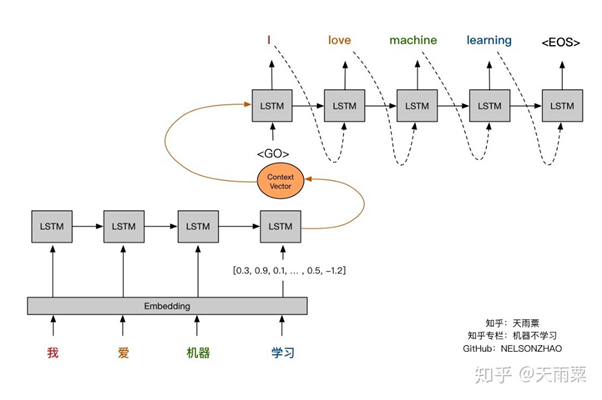

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


In [ ]:
import pandas as pd

# Load dataset
data = pd.read_csv("Text_summarization.csv")

# Extract columns
id=data['id'].astype(str).tolist()
articles = data['article'].astype(str).tolist()
highlights = data['highlights'].astype(str).tolist()

# Define tokenizer and vocabulary size
VOCAB_SIZE = 10000
MAX_LEN_ARTICLE = 200  # Max length of input article
MAX_LEN_SUMMARY = 50   # Max length of output summary

# Tokenize articles
article_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
article_tokenizer.fit_on_texts(articles)
article_sequences = article_tokenizer.texts_to_sequences(articles)
article_padded = pad_sequences(article_sequences, maxlen=MAX_LEN_ARTICLE, padding='post')

# Tokenize summaries
summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
summary_tokenizer.fit_on_texts(highlights)
summary_sequences = summary_tokenizer.texts_to_sequences(highlights)
summary_padded = pad_sequences(summary_sequences, maxlen=MAX_LEN_SUMMARY, padding='post')

# Shift decoder input and output
decoder_input = summary_padded[:, :-1]
decoder_output = summary_padded[:, 1:]


In [ ]:
# Encoder
encoder_inputs = Input(shape=(MAX_LEN_ARTICLE,))
encoder_embedding = Embedding(VOCAB_SIZE, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)


In [ ]:
# Attention layer
attention = tf.keras.layers.Attention()
# Decoder
decoder_inputs = Input(shape=(MAX_LEN_SUMMARY - 1,))
decoder_embedding = Embedding(VOCAB_SIZE, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Apply attention
attention_context = attention([decoder_outputs, encoder_outputs])

# Use tf.keras.layers.Concatenate instead of tf.concat
decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_context])

# Dense output layer
decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)


In [ ]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 49)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 256)       │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 49, 256)        │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 200, 256),     │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 49, 256),      │        525,312 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 49, 256)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 49, 512)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 49, 10000)      │      5,130,000 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,300,624 (43.11 MB)

 Trainable params: 11,300,624 (43.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
BATCH_SIZE = 64
EPOCHS = 1

history = model.fit(
    [article_padded, decoder_input],
    decoder_output,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9222s 7s/step - accuracy: 0.2622 - loss: 5.2761 - val_accuracy: 0.2918 - val_loss: 4.6803


In [ ]:
# Sample article
sample_article = articles[0]  # Replace with any index to test different articles
sample_sequence = article_tokenizer.texts_to_sequences([sample_article])
sample_padded = pad_sequences(sample_sequence, maxlen=MAX_LEN_ARTICLE, padding='post')

# Get the encoder's internal layers for prediction
encoder_model = tf.keras.Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Encode the input using the encoder model
encoder_out, enc_h, enc_c = encoder_model(sample_padded)

# Start the decoding process
summary = []
decoder_input = np.zeros((1, 1))  # Start with <start> token
decoder_input[0, 0] = summary_tokenizer.word_index.get('<start>', 0)

# Create a separate Embedding layer for prediction
# This layer will have the same configuration as the decoder_embedding layer in your model
decoder_embedding_layer = Embedding(VOCAB_SIZE, 256)

for _ in range(MAX_LEN_SUMMARY):
    # Predict next token
    # Use the new decoder_embedding_layer here
    decoder_embedding_step = decoder_embedding_layer(decoder_input)
    decoder_output_step, dec_h, dec_c = decoder_lstm(decoder_embedding_step, initial_state=[enc_h, enc_c])
    attention_step = attention([decoder_output_step, encoder_out])
    combined_step = tf.keras.layers.Concatenate(axis=-1)([decoder_output_step, attention_step])
    token_probs = decoder_dense(combined_step)

    # Get the predicted token
    predicted_token = np.argmax(token_probs[0, 0])
    if predicted_token == 0:  # End token
        break
    summary.append(predicted_token)

    # Prepare the next input
    decoder_input[0, 0] = predicted_token
    enc_h, enc_c = dec_h, dec_c

# Convert token indices back to words
predicted_summary = " ".join(
    [summary_tokenizer.index_word.get(token, '') for token in summary]
)
print("Original Article:the cat sat on the mat", "the dog chased the ball", sample_article)
print("Generated Summary:", predicted_summary)

Original Article:the cat sat on the mat the dog chased the ball the cat sat on the mat
Generated Summary:cat on mat dog chased ball on on on


In [ ]:
model.save('model.h5')